# Fit scattering data for polydisperse platelets

## Instructions

**About**\
With this notebook, you may fit scattering data of polydisperse platelets spanning a range of thicknesses L and radii R as is proposed in the manuscript "Morphological analysis of polydisperse nanoplatelets using SAXS" (2024) by L.S. van Hazendonk, R. Tuinier, E. Foschino, L. Matthews, H. Friedrich and M. Vis. Please cite the manuscript when using this script.

**To run this script, you need the following:**
* *.csv file with your averaged and merged SAXS data of the *q*-range of interest (example file: "E72 SAXS data merged.csv")
* (optional) Pre-calculated form factor table ("P11_table.csv"). Alternatively, you may calculate your own table spanning a range of thicknesses and radii of your own interest. Be aware that the calculation of this form factor table takes rather long depending on the number of data points in there. 

**Some tips for a better fit result:**
* When your fitting is slow or gives poor results, it might be worthwhile to change the bin size or to eliminate any noisy data ranges in the low- or high-*q* regions.
* Increasing the resolution of the form factor table, i.e. decreasing the step size, generally improves the fit result. 

**Fitting time:**
The fitting with a pre-generated form factor table should not take long (< 30 s for the example data file E72 from the manuscript (gibbsite) run on a 4-year old HP EliteBook 830 G6 with an Intel(R) Core(TM) i7-8665U CPU @ 1.90GHz processor, 32 GB RAM and a 64-bit Windows 11 operating system with an Anaconda Python distribution with Jupyter Notebook version 6.5.2). Be aware that the calculation of a new form factor table takes a number of hours depending on the number of data points in your table.

### Preliminaries

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

## Read and bin data

In [61]:
# Read data (csv)
columns = ["q", "I"]
input_data = pd.read_csv("E72 SAXS data merged.csv", names=columns, usecols=[0, 1]) # Replace with your data file name

#ln of q and I
log_data  = np.log(input_data)

bin_width = 0.05

if isinstance(bin_width, (int, float)):
    # Calculate bin edges
    bin_edges = np.arange(log_data["q"].min(), log_data["q"].max(), bin_width)

    # Bin the data based on q values
    log_data['bin'] = pd.cut(log_data['q'], bins=bin_edges)

    # Calculate mean values and standard deviation for each bin
    log_binned_data = log_data.groupby('bin', observed=True).agg({
        'q': ['mean'],
        'I': ['mean', 'std'],
        'bin': 'count'
    })

    # Rename columns for clarity
    log_binned_data.columns = ['ln(q)_center', 'mean_ln(I)', 'std_mean_ln(I)', 'count']

    # Add 1 column with std(I) in each bin (divide by sqrt(N))
    log_binned_data["std_mean_ln(I)"] /= np.sqrt(log_binned_data["count"])

    # Reset the index for a cleaner DataFrame
    log_binned_data.reset_index(inplace=True)

# Display the final DataFrame
log_binned_data.head()

,bin,ln(q)_center,mean_ln(I),std_mean_ln(I),count
0,"(-5.273, -5.223]",-5.244436,4.904700,NaN,1
1,"(-5.223, -5.173]",-5.203084,4.885888,0.005718,2
2,"(-5.173, -5.123]",-5.150361,4.869287,0.000069,2
3,"(-5.123, -5.073]",-5.100279,4.867757,0.001773,2
4,"(-5.073, -5.023]",-5.052586,4.861590,0.005385,2


In [62]:
## take the exponent to return to the real values to compare with mathematica script
q_values=np.exp(np.array(log_binned_data['ln(q)_center']))
mean_I_values=np.exp(np.array(log_binned_data['mean_ln(I)']))
std_mean_I_values=np.abs(mean_I_values)*(np.array(log_binned_data['std_mean_ln(I)']))

binned_data = pd.DataFrame({
    'q_values': q_values,
    'mean_I_values': mean_I_values,
    'std_mean_I_values': std_mean_I_values
})

binned_data.head()

,q_values,mean_I_values,std_mean_I_values
0,0.005277,134.922457,NaN
1,0.005500,132.407976,0.757113
2,0.005797,130.228030,0.009021
3,0.006095,130.028884,0.230476
4,0.006393,129.229508,0.695847


### Compute slopes ('n')

In [63]:
## Compute slopes in the binned ln data and in the ln data
# (here you lose 1 data point when doing the moving average)
# save it in dataframe called slopes_binned_data

slopes_log_binned_data = (np.array(log_binned_data["mean_ln(I)"][1:]) - np.array(log_binned_data["mean_ln(I)"][:-1]))/(np.array(log_binned_data["ln(q)_center"][1:]) - np.array(log_binned_data["ln(q)_center"][:-1]))
q_log_binned_data = (np.array(log_binned_data["ln(q)_center"][1:]) + np.array(log_binned_data["ln(q)_center"][:-1]))*0.5
std_slope  = np.sqrt((np.array(log_binned_data["std_mean_ln(I)"][1:])**2 + np.array(log_binned_data["std_mean_ln(I)"][:-1])**2))/(np.array(log_binned_data["ln(q)_center"][1:]) - np.array(log_binned_data["ln(q)_center"][:-1]))

## Save in a dataframe
slopes_binned_data = pd.DataFrame({
    'ln_q': q_log_binned_data,
    'q' : np.exp(q_log_binned_data),
    'slope': slopes_log_binned_data,
    'std_slope': std_slope
})

slopes_binned_data.head()

,ln_q,q,slope,std_slope
0,-5.223760,0.005387,-0.454935,NaN
1,-5.176723,0.005646,-0.314868,0.108461
2,-5.125320,0.005944,-0.030558,0.035419
3,-5.076433,0.006242,-0.129300,0.118862
4,-5.024345,0.006576,-0.150815,0.142780


Text(0.5, 1.0, 'slopes of binned log data')

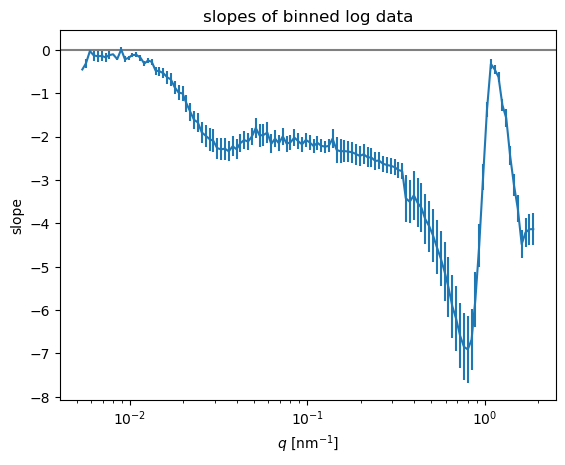

In [64]:
plt.errorbar(x=np.exp(np.array(slopes_binned_data["ln_q"])),y=slopes_binned_data["slope"],yerr=slopes_binned_data["std_slope"] )
plt.axhline(0,c="grey")
plt.xlabel(r"$q$ [nm$^{-1}]$")
plt.ylabel("slope")
plt.xscale("log")
plt.title("slopes of binned log data")

## Fit the data

### Set the values corresponding to your (imported) form factor table


In [66]:
## Set the settings corresponding to your imported table 
# (or adjust to your own preferences and regenerate the table in the cell below)
# The values below correspond to "P11_table.csv."

# Parameters for qlist
qmin = -3
qmax = 1
qstep = 0.02

# Generate qlist
qlist = 10**np.arange(qmin, qmax + qstep, qstep)

# Calculate qlistslope
#qlistslope = np.exp(np.convolve(np.log(qlist), np.ones(2)/2, mode='valid'))

# Parameters for lengths
lengthmin = -1
lengthmax = 3
lengthstep = 0.02

# Generate lengths
lengths = 10**np.arange(lengthmin, lengthmax + lengthstep, lengthstep)

# Parameters for radii
radiusmin = 1
radiusmax = 4
radiusstep = 0.02

# Generate radii
radii = 10**np.arange(radiusmin, radiusmax + radiusstep, radiusstep)

# Print or use generated lists as needed
print("qlist:", len(qlist))
print("radii:", len(radii))
print("lengths:", len(lengths))


qlist: 201
radii: 151
lengths: 201


### (Optional!) Compute a new form factor table
Beware: takes a number of hours depending on the range and step size of your L and R parameters.
Skip this step if you want to import a form factor table.

In [8]:
## compute the P11 and save it in a dataframe

# from scipy.integrate import quad
# from scipy.special import jn
# from itertools import product

# def P11(q, R, L):
#     integrand = lambda alpha: ((2 * jn(1, q * R * np.sin(alpha))) / (q * R * np.sin(alpha)) * np.sin((q * L * np.cos(alpha)) / 2) / ((q * L * np.cos(alpha)) / 2))**2 * np.sin(alpha)
#     result, error = quad(integrand, 0, np.pi/2)
#     return result

# data_all_lengths = np.zeros((len(qlist), len(radii),len(lengths)))
# combinations = np.zeros((len(qlist)*len(radii)*len(lengths),4))
# for k,q in enumerate(qlist):
#     for i, r in enumerate(radii):
#         for j, l in enumerate(lengths):
#             form_factor_value = P11(q, r, l)
#             data_all_lengths[k,i,j] = form_factor_value
#             combinations[k*len(lengths)*len(radii) + i*len(lengths)+j,0] = q
#             combinations[k*len(lengths)*len(radii) + i*len(lengths)+j,1] = r
#             combinations[k*len(lengths)*len(radii) + i*len(lengths)+j,2] = l
#             combinations[k*len(lengths)*len(radii) + i*len(lengths)+j,3] = form_factor_value
            
# # Save data to the file as .npy
# #np.save(filename, data_all_lengths)
# # Creating a DataFrame
# columns = ['q', 'R', 'L', 'P11']
# df = pd.DataFrame(combinations, columns=columns)

# # # Save the DataFrame to a CSV file
# df.to_csv('P11_newtable.csv', index=False)

### Import an existing form factor table

In [67]:
### load the dataframe with the form factor
#read form factor from csv file

file_path = 'P11_table.csv'
df_old= pd.read_csv(file_path)

# Display the DataFrame
df_old

,q,R,L,P11
0,0.001,10.0,0.100000,9.999833e-01
1,0.001,10.0,0.104713,9.999833e-01
2,0.001,10.0,0.109648,9.999833e-01
3,0.001,10.0,0.114815,9.999833e-01
4,0.001,10.0,0.120226,9.999833e-01
...,...,...,...,...
6100546,10.000,10000.0,831.763771,8.934717e-20
6100547,10.000,10000.0,870.963590,1.234475e-19
6100548,10.000,10000.0,912.010839,1.356450e-19
6100549,10.000,10000.0,954.992586,1.145389e-19


In [68]:
df = df_old ## copy in case you make some mistakes while reading data etc

### Reshape form factor table
Needed both in case of importing a table and generating a new one.

In [69]:
data_all_lengths=np.array(df["P11"]).reshape(len(qlist),len(radii),len(lengths))
data_all_lengths.shape

(201, 151, 201)

### Define fit functions

In [70]:
## Probability function

from scipy.stats import norm

def probfunc(mu_r, sigma_r, mu_l, sigma_l, r,l):
    pdf_r = norm.pdf(np.log(r), loc=mu_r, scale=sigma_r)
    pdf_l = norm.pdf(np.log(l), loc=mu_l, scale=sigma_l)
    den = l * r 
    return (pdf_r * pdf_l) / den

##Example probability function
# mul = 1.0
# sigmal = 0.5
# mur = 2.0
# sigmar = 0.8
# x=np.linspace(0.07,7.0,100)
# plt.plot(x,probfunc(mul,sigmal,mur,sigmar,x,x))  # (same as with mathematica)

In [71]:
## Fit function

#μL = 0.717,  ̃σL = 0.908,  ̃μD = 5.33,  ̃σD = 0.603.
#    μL = 1.85,  ̃σL = 0.193,  ̃μD = 5.15,  ̃σD = 0.147

def to_minimize(params):
    muR=params[0]
    sigmaR=params[1]
    muL=params[2]
    sigmaL=params[3]

    R, L = np.meshgrid(radii, lengths)
    term1 = L**2 * R**4 # volume term
    term2 = (10**(np.log10(R) + radiusstep/2) - 10**(np.log10(R) - radiusstep/2)) # correction for bin width R
    term3 = (10**(np.log10(L) + lengthstep/2) - 10**(np.log10(L) - lengthstep/2)) # correction for bin width L
    probabilities = term1 * term2 * term3 * probfunc(abs(muR), abs(sigmaR), abs(muL), abs(sigmaL), R, L)

    sum_prob=np.sum(probabilities)
    normalized_probabilities = probabilities.T / sum_prob

    theo_I = np.sum(normalized_probabilities[None, :, :] * data_all_lengths, axis=(1, 2))

    logtheoI = np.log(theo_I)
    logqlist=np.log(qlist)
    
    # compute slopes of theoretical values
    slopes_theo = (logtheoI[1:] - logtheoI[:-1])/(logqlist[1:] - logqlist[:-1])
    q_theo = (logqlist[1:] + logqlist[:-1])*0.5

    # calculate difference between theoretical and experimental slopes
    slopes_theo_val=[]
    q_vals = []
    ln_q = np.array(slopes_binned_data['ln_q'])
    start_index = np.abs(q_theo-ln_q[0]).argmin()
    stop_index = np.abs(q_theo-ln_q[-1]).argmin()
    for q_exp_value_to_match in ln_q:
        closest_qtheo_index = np.abs(q_theo[start_index:stop_index] - q_exp_value_to_match).argmin()
        q_vals.append(q_theo[closest_qtheo_index+start_index])
        slopes_theo_val.append(slopes_theo[closest_qtheo_index+start_index])
    diff = slopes_theo_val - np.array(slopes_binned_data['slope'])
    squares=np.dot(diff,diff)
    #squares = np.linalg.norm(slopes_theo_val - slopes_binned_data['slope'])
    print(params, squares)
    return squares

### Fit the data

In [72]:
from scipy.optimize import minimize

# Initial guess
mu_r= np.log(250.)
sigma_r=0.5
mu_l=np.log(30.)
sigma_l=0.5

initial_guess = [ mu_r, sigma_r,mu_l, sigma_l]

# Constraint: sigmal and sigmar parameters must be greater than 0
#constraint0 = ({'type': 'ineq', 'fun': lambda params: params[1]})
#constraint1 = ({'type': 'ineq', 'fun': lambda params: params[3]})
#bounds = ([0.0, 0.01, 0.0, 0.01],[50.0,5.0, 50.0, 5.0])
#bounds = ([0.0, 0.01, 0.0, 0.01],[50.0,5.0, 50.0, 5.0])
#options = {'disp': True, 'eps': 0.1}

# Perform the minimization
import time # calculate the fitting time

st = time.time()
resultNEW = minimize(to_minimize, initial_guess,method='BFGS')
et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')
# Print the result
print(resultNEW)

[5.52146092 0.5        3.40119738 0.5       ] 302.4599256595935
[5.52146093 0.5        3.40119738 0.5       ] 302.4599258916411
[5.52146092 0.50000001 3.40119738 0.5       ] 302.459925773569
[5.52146092 0.5        3.4011974  0.5       ] 302.45992681264136
[5.52146092 0.5        3.40119738 0.50000001] 302.45992613196466
[5.33729502 0.40954269 2.48607427 0.1250999 ] 619.4567511058397
[5.33729503 0.40954269 2.48607427 0.1250999 ] 619.4567528059063
[5.33729502 0.40954271 2.48607427 0.1250999 ] 619.4567532025884
[5.33729502 0.40954269 2.48607428 0.1250999 ] 619.4567353076981
[5.33729502 0.40954269 2.48607427 0.12509991] 619.4566334288872
[5.45662078 0.46815228 3.07900577 0.36800719] 282.9282018387877
[5.45662079 0.46815228 3.07900577 0.36800719] 282.92820228210667
[5.45662078 0.46815229 3.07900577 0.36800719] 282.92820195770474
[5.45662078 0.46815228 3.07900578 0.36800719] 282.92820271579313
[5.45662078 0.46815228 3.07900577 0.36800721] 282.9282006306353
[5.30998273 0.41308207 2.57781292 0.

[ 4.23054989 -0.01696392  1.89536088  0.14406831] 62.65116281281804
[ 4.23054989 -0.01696392  1.89536087  0.14406833] 62.651132260341896
[ 4.30896114 -0.02981876  2.01717334  0.28432091] 90.65944845644138
[ 4.30896116 -0.02981876  2.01717334  0.28432091] 90.65944861706865
[ 4.30896114 -0.02981875  2.01717334  0.28432091] 90.65945265673841
[ 4.30896114 -0.02981876  2.01717335  0.28432091] 90.659453848203
[ 4.30896114 -0.02981876  2.01717334  0.28432093] 90.6594491973286
[ 4.25218958 -0.02051156  1.92897829  0.18277478] 48.717956272775645
[ 4.25218959 -0.02051156  1.92897829  0.18277478] 48.71795002670488
[ 4.25218958 -0.02051154  1.92897829  0.18277478] 48.717961280406755
[ 4.25218958 -0.02051156  1.9289783   0.18277478] 48.71796665326238
[ 4.25218958 -0.02051156  1.92897829  0.1827748 ] 48.71795201131186
[ 3.74233815  0.05531472  1.05212617 -0.68626691] 171.19314649393394
[ 3.74233816  0.05531472  1.05212617 -0.68626691] 171.19314528852317
[ 3.74233815  0.05531474  1.05212617 -0.686266

[ 4.39115687 -0.03393863  1.85992398  0.19041945] 15.662707714183071
[ 4.39115686 -0.03393861  1.85992398  0.19041945] 15.662708405247084
[ 4.39115686 -0.03393863  1.859924    0.19041945] 15.662707762799108
[ 4.39115686 -0.03393863  1.85992398  0.19041946] 15.662707540922167
[ 4.39890292 -0.03855005  1.86222938  0.1905639 ] 15.451299916895433
[ 4.39890294 -0.03855005  1.86222938  0.1905639 ] 15.451299903563688
[ 4.39890292 -0.03855004  1.86222938  0.1905639 ] 15.451300880766759
[ 4.39890292 -0.03855005  1.8622294   0.1905639 ] 15.451300349086964
[ 4.39890292 -0.03855005  1.86222938  0.19056392] 15.451299777960099
[ 4.42988719 -0.05699576  1.87145097  0.19114171] 14.369582758862204
[ 4.42988721 -0.05699576  1.87145097  0.19114171] 14.369582444619057
[ 4.42988719 -0.05699574  1.87145097  0.19114171] 14.369583636316737
[ 4.42988719 -0.05699576  1.87145098  0.19114171] 14.369584467831647
[ 4.42988719 -0.05699576  1.87145097  0.19114173] 14.369582650502212
[ 4.53821695 -0.11932721  1.899870

[ 4.46207357 -0.14934682  1.85696759  0.19065229] 11.258760089134348
[ 4.46207359 -0.14934682  1.85696759  0.19065229] 11.258760089134421
[ 4.46207357 -0.14934681  1.85696759  0.19065229] 11.258760089134496
[ 4.46207357 -0.14934682  1.85696761  0.19065229] 11.258760089134684
[ 4.46207357 -0.14934682  1.85696759  0.1906523 ] 11.258760089133967
[ 4.46207359 -0.1493468   1.85696759  0.19065229] 11.258760089134348
[ 4.46207361 -0.1493468   1.85696759  0.19065229] 11.258760089134519
[ 4.46207359 -0.14934679  1.85696759  0.19065229] 11.258760089134302
[ 4.46207359 -0.1493468   1.85696761  0.19065229] 11.258760089134489
[ 4.46207359 -0.1493468   1.85696759  0.1906523 ] 11.258760089134212
[ 4.4620736  -0.1493468   1.85696759  0.19065229] 11.258760089134281
[ 4.46207361 -0.1493468   1.85696759  0.19065229] 11.25876008913432
[ 4.4620736  -0.14934679  1.85696759  0.19065229] 11.258760089134249
[ 4.4620736  -0.1493468   1.85696761  0.19065229] 11.258760089134583
[ 4.4620736  -0.1493468   1.8569675

[ 4.46207359 -0.1493468   1.85696759  0.19065229] 11.258760089134183
[ 4.46207361 -0.1493468   1.85696759  0.19065229] 11.258760089134373
[ 4.46207359 -0.14934679  1.85696759  0.19065229] 11.258760089134293
[ 4.46207359 -0.1493468   1.85696761  0.19065229] 11.258760089134505
[ 4.46207359 -0.1493468   1.85696759  0.1906523 ] 11.25876008913427
[ 4.46207359 -0.1493468   1.85696759  0.19065229] 11.258760089134196
[ 4.46207361 -0.1493468   1.85696759  0.19065229] 11.258760089134489
[ 4.46207359 -0.14934679  1.85696759  0.19065229] 11.258760089134416
[ 4.46207359 -0.1493468   1.85696761  0.19065229] 11.258760089134583
[ 4.46207359 -0.1493468   1.85696759  0.1906523 ] 11.258760089134217
[ 4.46207359 -0.1493468   1.85696759  0.19065229] 11.25876008913435
[ 4.46207359 -0.1493468   1.85696759  0.19065229] 11.2587600891343
[ 4.46207359 -0.1493468   1.85696759  0.19065229] 11.258760089134427
[ 4.46207359 -0.1493468   1.85696759  0.19065229] 11.258760089134324
[ 4.46207359 -0.1493468   1.85696759  

### Display fit parameters

In [73]:
## Fit parameters μL, ̃σL, ̃μD, ̃σD
## Extract fit parameters from cells above
muL= abs(resultNEW['x'][2])
sigmaL = abs(resultNEW['x'][3])
muR = abs(resultNEW['x'][0])
sigmaR = abs(resultNEW['x'][1])

# Calculate expected value and standard deviation (not on log scale)
muLx = np.exp(muL + sigmaL**2/2)
sigmaLx = np.exp(muL) * np.sqrt(np.exp(sigmaL**2) * (np.exp(sigmaL**2) - 1))
muRx = np.exp(muR + sigmaR**2/2)
sigmaRx = np.exp(muR) * np.sqrt(np.exp(sigmaR**2) * (np.exp(sigmaR**2) - 1))

# convert radius to diameter
muD = muR + np.log(2)
sigmaD = sigmaR
muDx = 2*muRx
sigmaDx = 2*sigmaRx

params = [muL, sigmaL, muR, sigmaR, muLx, sigmaLx, muRx, sigmaRx, muD, sigmaD, muDx, sigmaDx]

print(params)

[1.8569675935593666, 0.19065228830921502, 4.462073596724697, 0.1493468003407359, 6.521743453769023, 1.2547700759996905, 87.63897596618733, 13.161924485054966, 5.155220777284643, 0.1493468003407359, 175.27795193237466, 26.323848970109932]


## Plots

### Calculate theoretical intensities and slopes based on fit parameters

In [74]:
## Calculate probabilities based on the fit parameters
R,L = np.meshgrid(radii, lengths)
term1 = L**2 * R**4
term2 = (10**(np.log10(R) + radiusstep/2) - 10**(np.log10(R) - radiusstep/2))
term3 = (10**(np.log10(L) + lengthstep/2) - 10**(np.log10(L) - lengthstep/2))
probabilities = term1 * term2 * term3 * probfunc(abs(muR), abs(sigmaR), abs(muL), abs(sigmaL), R, L)
sum_prob=np.sum(probabilities)
normalized_probabilities = probabilities.T / sum_prob

theo_I = np.sum(normalized_probabilities[None,:, :] * data_all_lengths, axis=(1, 2))

logtheoI = np.log(theo_I)
logqlist=np.log(qlist)

## Compute slopes of theoretical values
slopes_theo = (logtheoI[1:] - logtheoI[:-1])/(logqlist[1:] - logqlist[:-1])
q_theo = (logqlist[1:] + logqlist[:-1])*0.5

slopes_theo_val=[]
q_vals = []
ln_q = np.array(slopes_binned_data['ln_q'])
start_index = np.abs(q_theo-ln_q[0]).argmin()
stop_index = np.abs(q_theo-ln_q[-1]).argmin()
for q_exp_value_to_match in ln_q:
    closest_qtheo_index = np.abs(q_theo[start_index:stop_index] - q_exp_value_to_match).argmin()
    q_vals.append(q_theo[closest_qtheo_index+start_index])
    slopes_theo_val.append(slopes_theo[closest_qtheo_index+start_index])

### Choose output folder
Only necessary if you want to export your plots.

In [75]:
# outpath = r"C:\Users\Analysis\Python\Figures" # Example path
# outpath = r"C:\Users\s168562\OneDrive - TU Eindhoven\PhD\4_Colloidal_interactions\Manuscript SAXS\Data & Code\SAXS analysis Python\Working example (E72)"

# Plot preliminaries
# plt.style.use('default') # default, ggplot, seaborn-*, dark_background, fivethirtyeight
# plt.rcParams['font.size'] = 8 # set plot font size matplotlib
# cm = 1/2.54  # convert centimeters to inches

### Plot the slope fit

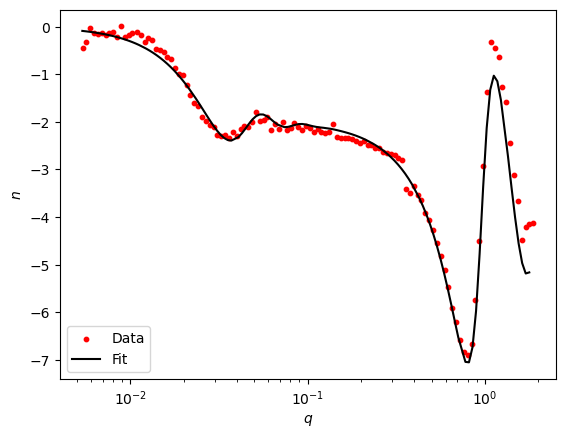

In [76]:
# plt.figure(figsize= [5.5*cm, 3.8*cm])
plt.figure()
ax = plt.axes()
# plt.scatter(slopes_binned_data['ln_q'],slopes_binned_data['slope'],label="Data",s=10, color = "red")
# plt.plot(q_vals,slopes_theo_val,label="Fit", color = "black")
plt.scatter(slopes_binned_data['q'],slopes_binned_data['slope'],label="Data",s=10, color = "red")
plt.plot(np.exp(q_vals),slopes_theo_val,label="Fit", color = "black")
plt.ylabel("$n$")
plt.xlabel("$q$")
ax.set_xscale('log')
plt.legend()
# figurepath = os.path.join(outpath, "SlopeFit.pdf")
# plt.savefig(figurepath, dpi = 300, bbox_inches='tight', transparent = True)

### Plot the fit on top of the intensity curve

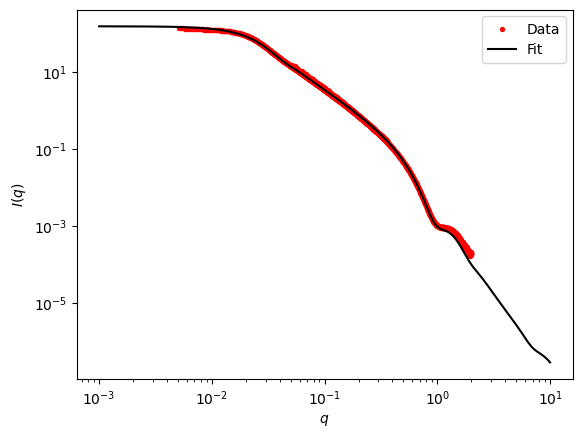

In [78]:
rescale = 150 # fudge factor to match the calculated intensity with the experimental intensity

plt.figure()
plt.scatter(input_data['q'],input_data['I'],label="Data",s=8, color = "red")
plt.loglog(qlist,rescale*theo_I,label="Fit", color = "black")
plt.ylabel("$I(q)$")
plt.xlabel("$q$")
plt.legend()
# figurepath = os.path.join(outpath, "IntensityFit.pdf")
# plt.savefig(figurepath, dpi = 300, bbox_inches='tight', transparent = True)

### Plot the size distributions

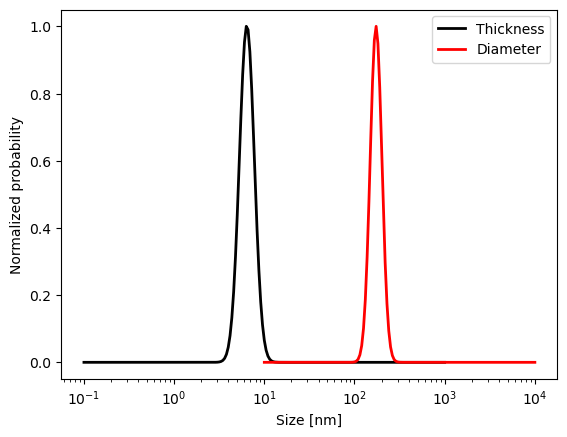

In [79]:
pdf_r = norm.pdf(np.log(radii), loc=muD, scale=sigmaR)
pdf_l = norm.pdf(np.log(lengths), loc=muL, scale=sigmaL)

# plt.figure(figsize= [5.5*cm, 3.8*cm])
plt.figure()
ax = plt.axes()
plt.plot(lengths,pdf_l/pdf_l.max(), label="Thickness", color = "black", linewidth = 2) 
plt.plot(radii,pdf_r/pdf_r.max(), label="Diameter", color = "red", linewidth = 2) 
ax.set_xscale('log')
plt.xlabel(r'Size [nm]')
plt.ylabel(r'Normalized probability')
plt.legend()
# figurepath = os.path.join(outpath, "Distributions.pdf")
# plt.savefig(figurepath, dpi = 300, bbox_inches='tight', transparent = True)